# Take a look at specific samples before and after decontX

Create a figure for the supplement (probably) that shows one of UMAP, dotplot (genes), dotplot (programs), violins (gene), violins (program), that demonstrates the effects of cleaning up data with decontX and compare that with CellBender.

Stephen Fleming
20210125

In [1]:
# set this for a sample of interest

sample = '02-P005175-S053-R01'

In [2]:
import pandas as pd
import numpy as np

import scanpy as sc
import harmony
from harmony import harmonize

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc.__version__

'1.6.1'

## Grab data

In [4]:
from typing import List
import anndata
import gc


def get_data(sample: str,
             n_umi_cutoff: int = 0,
             n_gene_cutoff: int = 0,
             cellranger_directory: str = '/home/jupyter-user/data/cellranger/',
             cellbender_directory: str = '/home/jupyter-user/data/cellbender_v2/',
             decontx_directory: str = '/home/jupyter-user/data/decontx/') -> anndata.AnnData:
    """Combine CellRanger, CellBender, and decontX data into one anndata object using layers."""
        
    print(sample)

    # find file
    filename = glob.glob(os.path.join(cellranger_directory, sample + '*.h5'))

    if len(filename) == 0:
        print(f'Skipping sample {sample}... it is assumed it failed QC.')
        return

    assert len(filename) == 1, f'file glob was {filename}'
    filename = filename[0]

    # load data
    ad_tmp = sc.read_10x_h5(filename)
    ad_tmp.var_names_make_unique()
    ad_tmp.layers['cellranger'] = ad_tmp.X.copy()
    ad_tmp.obs['sample'] = sample

    # filter cells
    sc.pp.filter_cells(ad_tmp, 
                       min_counts=n_umi_cutoff, 
                       inplace=True)
    sc.pp.filter_cells(ad_tmp,  
                       min_genes=n_gene_cutoff, 
                       inplace=True)
    print(ad_tmp.shape)

    # cellbender data
    filename_cb = glob.glob(os.path.join(cellbender_directory, sample + '*.h5'))
    
    if len(filename_cb) == 0:
        print(f'Cannot find {sample} in CellBender folder... did it fail?')
        return

    assert len(filename_cb) == 1, f'file glob was {filename_cb}'
    filename_cb = filename_cb[0]
    
    ad_tmp_cb = sc.read_10x_h5(filename_cb)
    ad_tmp_cb.var_names_make_unique()
    
    # add to cellranger dataset
    ad_tmp = ad_tmp[ad_tmp_cb.obs.index]
    ad_tmp.layers['cellbender'] = ad_tmp_cb.X.copy()

    # rename cell barcodes
    ad_tmp.obs.index = sample + '-' + ad_tmp.obs.index
    ad_tmp.obs.index = [s[:-2] for s in ad_tmp.obs.index]
    
    # load decontx
    ad_tmp_de = read_decontx(os.path.join(decontx_directory, sample))
    ad_tmp_de.var_names_make_unique()
    
    # subset to barcodes and genes in decontx
    ad_tmp = ad_tmp[[bc in ad_tmp_de.obs_names for bc in ad_tmp.obs_names]]
    ad_tmp = ad_tmp[:, [g in ad_tmp_de.var_names for g in ad_tmp.var_names]]
    
    # subset decontx to included barcodes and genes
    ad_tmp_de = ad_tmp_de[[b in ad_tmp.obs_names for b in ad_tmp_de.obs_names]]
    ad_tmp_de = ad_tmp_de[:, [g in ad_tmp.var_names for g in ad_tmp_de.var_names]]
    
    # reorder decontx rows to match
    bc_order = [np.where(ad_tmp_de.obs.index == bc)[0].item() for bc in ad_tmp.obs.index]
    ad_tmp_de = ad_tmp_de[bc_order]
    
#     print(ad_tmp.var.head())
#     print(ad_tmp_de.var.head())
#     print(ad_tmp.obs.head())
#     print(ad_tmp_de.obs.head())
    
#     assert ad_tmp_de.var_names == ad_tmp.var_names, 'Problem... gene names do not agree'
#     assert ad_tmp_de.obs_names == ad_tmp.obs_names, 'Problem... barcodes do not agree'
    ad_tmp.layers['decontx'] = ad_tmp_de.X.copy()

    return ad_tmp


def get_pegasus_data(sample: str,
                     directory: str = '/home/jupyter-user/analysis/pegasus') -> anndata.AnnData:
    """Grab anndata object processed by pegasus."""
        
    print(sample)

    # find file
    print(os.path.join(directory, sample + '*.h5ad'))
    filename = glob.glob(os.path.join(directory, sample + '*.h5ad'))

    if len(filename) == 0:
        print(f'Skipping sample {sample}... it is assumed it failed QC.')
        return

    assert len(filename) == 1, f'file glob was {filename}'
    filename = filename[0]

    # load data
    ad_tmp = sc.read_h5ad(filename)
    print(ad_tmp.shape)

    return ad_tmp


def add_pegasus_annotations_to_adata(adata: anndata.AnnData, 
                                     adata_pegasus: anndata.AnnData, 
                                     obs_startswith: str = 'Lung',
                                     prefix: str= ''):
    """Add annotations from pegasus adata object to adata, with UMAP and leiden_labels."""
    
    # add the gene score annotations to adata
    for gene_set in [c for c in adata_pegasus.obs.columns if c.startswith(obs_startswith)]:
        adata.obs[prefix + gene_set] = adata_pegasus.obs[gene_set]
        
    # subset pegasus data
    adata_pegasus = adata_pegasus[[bc in adata.obs.index 
                                   for bc in adata_pegasus.obs.index]]
        
    # subset to the cells in the pegasus dataset
    adata = adata[adata_pegasus.obs.index]

    # add pegasus cell annotations
    adata.obsm[f'X_{prefix}umap'] = adata_pegasus.obsm['X_umap']
    adata.obs[f'{prefix}leiden_labels'] = adata_pegasus.obs['leiden_labels']
    
    return adata


def read_decontx(mtx_path: str, 
                 mtx_filename: str = 'matrix.mtx',
                 barcode_filename: str = 'barcodes.tsv',
                 genes_filename: str = 'genes.tsv'):
    """Read decontX output format file to anndata object."""
    
    import scipy.io as io
    mat = io.mmread(os.path.join(mtx_path, mtx_filename))
    bcs = np.genfromtxt(os.path.join(mtx_path, barcode_filename), dtype=str)
    genes = np.genfromtxt(os.path.join(mtx_path, genes_filename), dtype=str)
    
    name = mtx_path.rstrip('/').split('/')[-1]
    bcs = np.array([name + '-' + bc.split('_')[-1][:-2] for bc in bcs], dtype=str)
    
    adata =  anndata.AnnData(X=mat.transpose().tocsr(), 
                             obs=pd.DataFrame(bcs).set_index(0), 
                             var=pd.DataFrame(genes).set_index(0))
    adata.var.index.name = None
    adata.obs.index.name = None
    return adata

In [36]:
!ls -lh /home/jupyter-user/data/decontx/02-P005175-S053-R01/

total 282M
-rw-rw-r-- 1 jupyter-user users 256K Jan 25 17:15 barcodes.tsv
-rw-rw-r-- 1 jupyter-user users 563K Jan 25 17:15 genes.tsv
-rw-rw-r-- 1 jupyter-user users 281M Jan 25 17:13 matrix.mtx


In [5]:
adata = get_data(sample=sample, n_umi_cutoff=1)

02-P005175-S053-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(873511, 33567)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata

AnnData object with n_obs × n_vars = 9268 × 26312
    obs: 'sample', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'cellranger', 'cellbender', 'decontx'

In [7]:
adata.layers['cellranger']

<9268x26312 sparse matrix of type '<class 'numpy.float32'>'
	with 10283619 stored elements in Compressed Sparse Row format>

In [8]:
adata.layers['cellbender']

<9268x26312 sparse matrix of type '<class 'numpy.float32'>'
	with 9494110 stored elements in Compressed Sparse Row format>

In [9]:
adata.layers['decontx']

<9268x26312 sparse matrix of type '<class 'numpy.float32'>'
	with 10283821 stored elements in Compressed Sparse Row format>

In [10]:
adata_pegasus = get_pegasus_data(sample=sample)

02-P005175-S053-R01
/home/jupyter-user/analysis/pegasus/02-P005175-S053-R01*.h5ad
(8292, 25208)


In [11]:
adata = add_pegasus_annotations_to_adata(adata, adata_pegasus)

/home/jupyter-user/.local/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['W_pca'] that happens to be dimensioned at n_obs×n_obs (8292×8292).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,


In [12]:
adata

AnnData object with n_obs × n_vars = 8181 × 26312
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'
    layers: 'cellranger', 'cellbender', 'decontx'

## UMAP

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


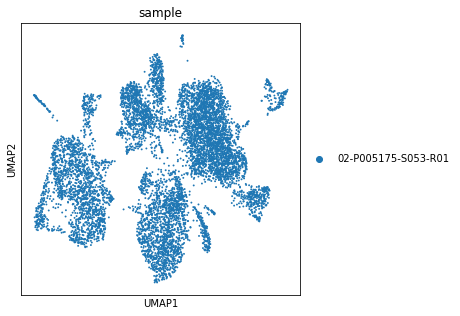

In [128]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='sample', ax=plt.gca())

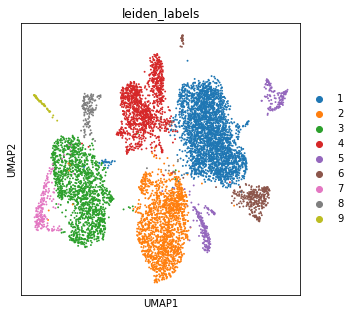

In [129]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='leiden_labels', ax=plt.gca())

In [13]:
adata.var['gene_name'] = [g[14:] for g in adata.var.index]

adata.var.index = adata.var['gene_name']

In [14]:
adata.var.head()

,gene_ids,feature_types,genome,gene_name
gene_name,,,,
AL627309.1,GRCh38premrna_ENSG00000238009,Gene Expression,GRCh38premrna,AL627309.1
AL627309.2,GRCh38premrna_ENSG00000239906,Gene Expression,GRCh38premrna,AL627309.2
AC114498.1,GRCh38premrna_ENSG00000235146,Gene Expression,GRCh38premrna,AC114498.1
AL669831.5,GRCh38premrna_ENSG00000237491,Gene Expression,GRCh38premrna,AL669831.5
FAM87B,GRCh38premrna_ENSG00000177757,Gene Expression,GRCh38premrna,FAM87B


## UMAP

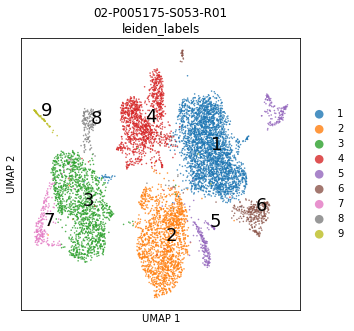

In [137]:
# umap

# show clustering with numbers

# key = 'leiden0.5'
key = 'leiden_labels'

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=10, alpha=0.8, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=18, color='black')

plt.title(f'{sample}\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [138]:
# cells per cluster

adata.obs[key].value_counts()

1    2875
2    1596
3    1426
4    1224
6     328
5     328
7     196
8     152
9      56
Name: leiden_labels, dtype: int64

## Marker genes via simple Wilcoxon test

In [139]:
# cursory marker genes via wilcoxon test

# key = 'leiden0.5'

sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)  # method='t-test_overestim_var')

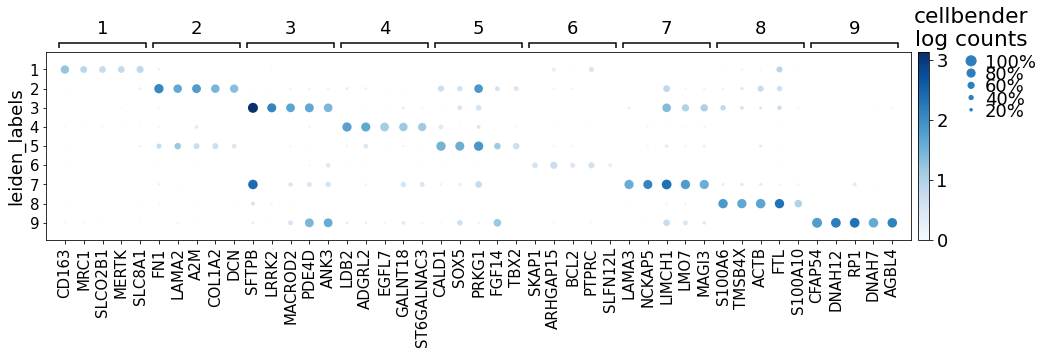

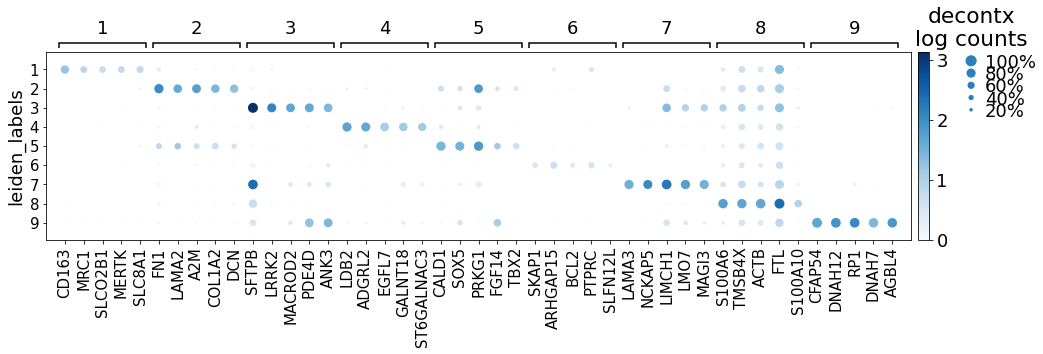

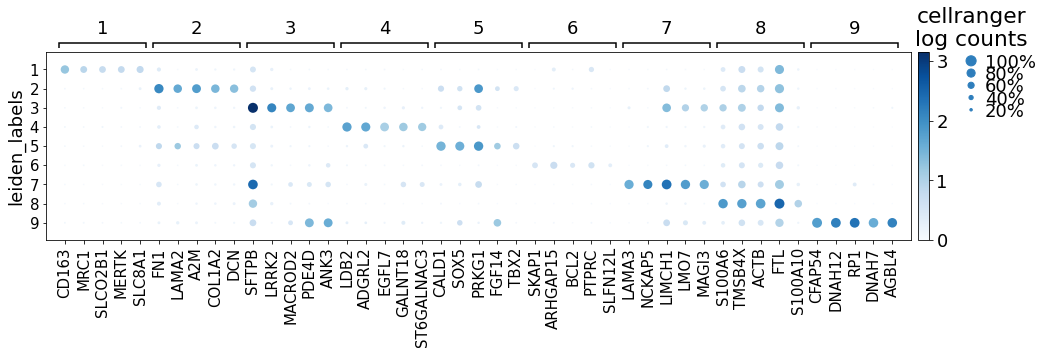

In [174]:
# plot marker genes for the outlier "clusters"
n = 5

# cluster_key = 'leiden0.5'
cluster_key = key

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 10)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    genes = []
    for g in marker_genes[k, :]:
        if (i < n 
            and g not in unique_markers 
            and g != 'nan'
            and g != 'MALAT1'
            and g not in [a for it in list(unique_markers.values()) for a in it]):
            genes.append(g)
            i += 1
    unique_markers.update({str(k + 1): genes})

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='cellbender',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellbender\nlog counts')
plt.gcf().savefig('/home/jupyter-user/analysis/figures/marker_dotplot_cellbender.pdf', 
                  bbox_inches='tight')
plt.show()

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='decontx',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('decontx\nlog counts')
plt.gcf().savefig('/home/jupyter-user/analysis/figures/marker_dotplot_decontx.pdf', 
                  bbox_inches='tight')
plt.show()

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='cellranger',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellranger\nlog counts')
plt.gcf().savefig('/home/jupyter-user/analysis/figures/marker_dotplot_cellranger.pdf', 
                  bbox_inches='tight')
plt.show()

## Specific dotplots

## Extended Data Figure 1h

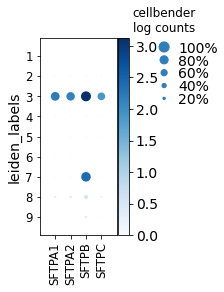

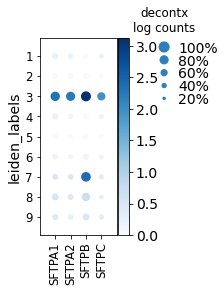

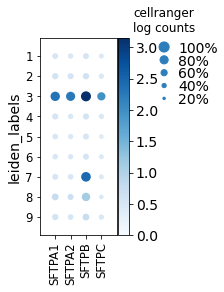

In [145]:
plt.rcParams.update({'font.size': 14})

# vmax = None
# cmap = 'PuRd'

vmin = 0  # -0.5
vmax = None
cmap = 'Blues'

genes = ['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC']

sc.pl.dotplot(adata, 
              var_names=genes, 
              layer='cellbender',
              groupby='leiden_labels',
              log=True,
#               standard_scale='var',
              color_map=cmap,
              vmin=vmin,
              vmax=vmax,
              smallest_dot=2,
              show=False)
plt.title('cellbender\nlog counts' + ('\n(values truncated)' 
                                      if vmax is not None else ''), fontsize=12)
plt.gcf().savefig('/home/jupyter-user/analysis/figures/surfactant_dotplot_cellbender.pdf', 
                  bbox_inches='tight')
plt.show()

sc.pl.dotplot(adata, 
              var_names=genes, 
              layer='decontx',
              groupby='leiden_labels',
              log=True,
#               standard_scale='var',
              color_map=cmap,
              vmin=vmin,
              vmax=vmax,
              smallest_dot=2,
              show=False)
plt.title('decontx\nlog counts' + ('\n(values truncated)' 
                                   if vmax is not None else ''), fontsize=12)
plt.gcf().savefig('/home/jupyter-user/analysis/figures/surfactant_dotplot_decontx.pdf', 
                  bbox_inches='tight')
plt.show()

sc.pl.dotplot(adata, 
              var_names=genes, 
              layer='cellranger',
              groupby='leiden_labels',
              log=True,
#               standard_scale='var',
              color_map=cmap,
              vmin=vmin,
              vmax=vmax,
              smallest_dot=2,
              show=False)
plt.title('cellranger\nlog counts' + ('\n(values truncated)' 
                                      if vmax is not None else ''), fontsize=12)
plt.gcf().savefig('/home/jupyter-user/analysis/figures/surfactant_dotplot_cellranger.pdf', 
                  bbox_inches='tight')
plt.show()

## A few violin plots

In [146]:
adata.var_names[adata.var_names.str.startswith('SFTP')]

Index(['SFTPB', 'SFTPC', 'SFTPA2', 'SFTPA1', 'SFTPD', 'SFTPD-AS1'], dtype='object', name='gene_name')

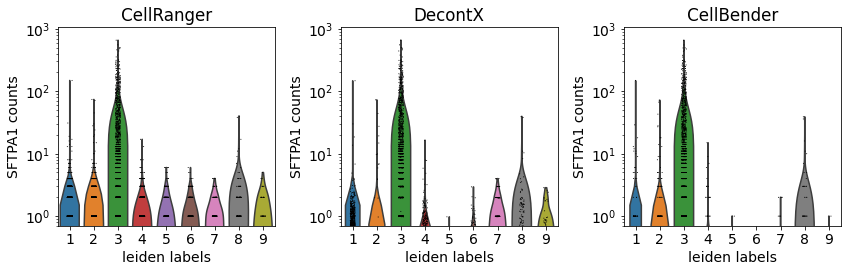

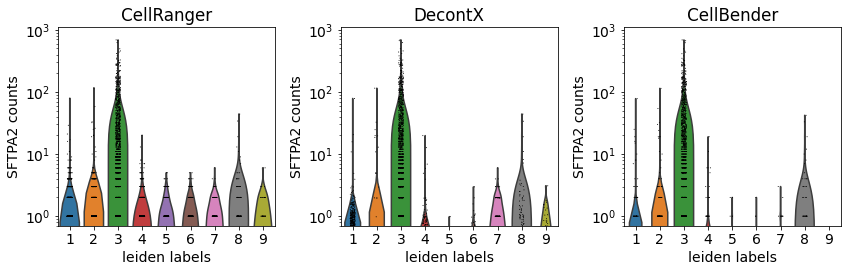

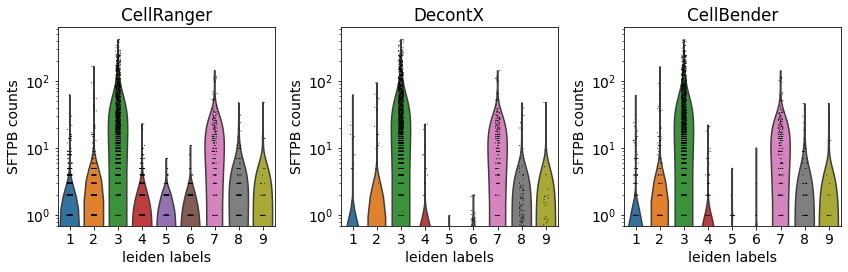

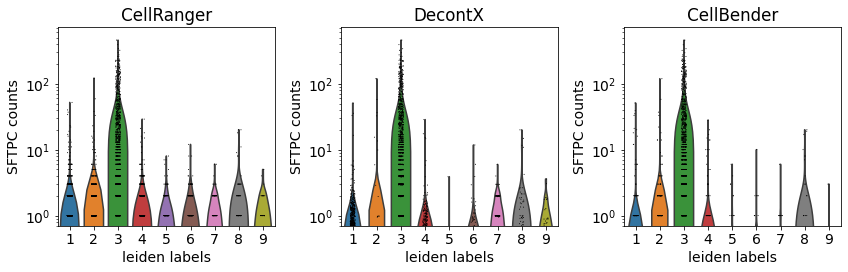

In [147]:
plt.rcParams.update({'font.size': 14})

for g in ['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC']:
    
    fig = plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    sc.pl.violin(adata, keys=g, ax=plt.gca(),
                 groupby=cluster_key, log=True, bw=0.5, layer='cellranger', show=False)
    plt.ylabel(f'{g} counts')
    plt.title('CellRanger')
    plt.ylim(bottom=7e-1)
    ytop = plt.gca().get_ylim()[-1]
    
    plt.subplot(1, 3, 2)
    sc.pl.violin(adata, keys=g, ax=plt.gca(),
                 groupby=cluster_key, log=True, bw=0.5, layer='decontx', show=False)
    plt.ylabel(f'{g} counts')
    plt.title('DecontX')
    plt.ylim([7e-1, ytop])
    
    plt.subplot(1, 3, 3)
    sc.pl.violin(adata, keys=g, ax=plt.gca(),
                 groupby=cluster_key, log=True, bw=0.5, layer='cellbender', show=False)
    plt.ylabel(f'{g} counts')
    plt.title('CellBender')
    plt.ylim([7e-1, ytop])
    
    plt.tight_layout()
    
    fig.savefig(f'/home/jupyter-user/analysis/figures/{g}_violin.pdf', bbox_inches='tight')
    
    plt.show()

## Genes overlaid on UMAPs

In [148]:
def plot_umap(adata, color, layer, colorbar_label, ax, **kwargs):
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]
    if color in adata.var_names:
        c = np.array(adata.layers[layer][:, adata.var_names == color].todense()).squeeze()
    else:
        c = adata.obs[color].values
    order = np.argsort(c)
    im = ax.scatter(x=x[order], y=y[order], c=c[order], **kwargs)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    cbar = plt.gcf().colorbar(im, aspect=30)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, labelpad=15)

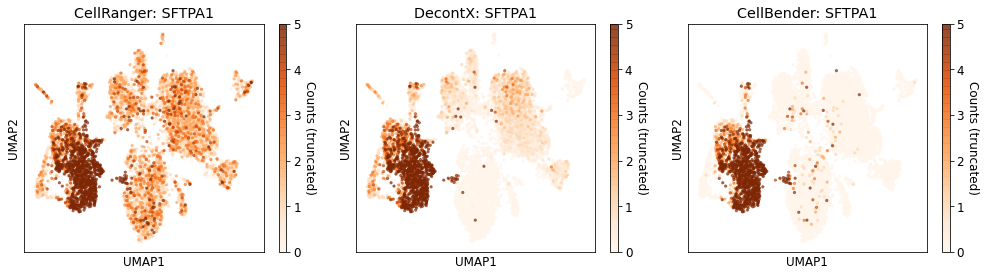

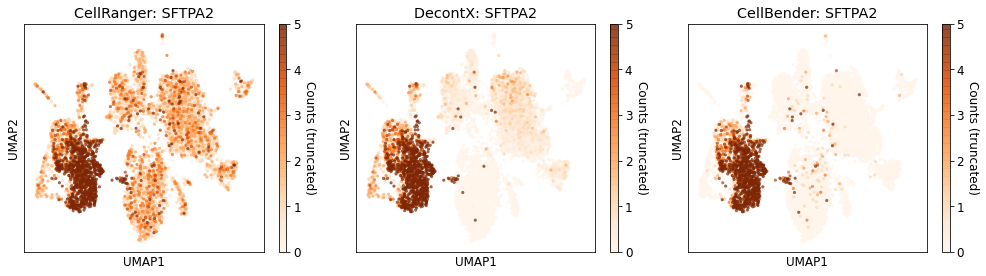

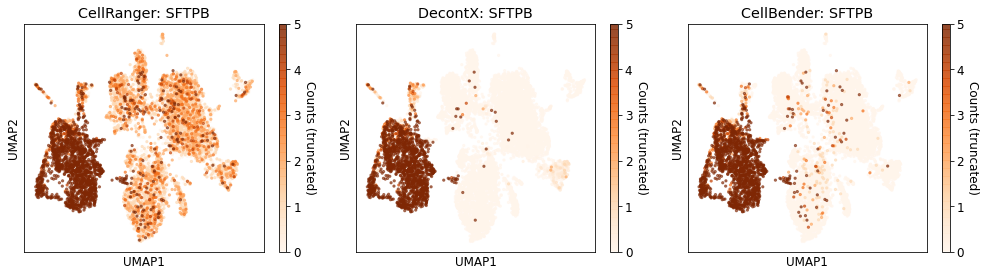

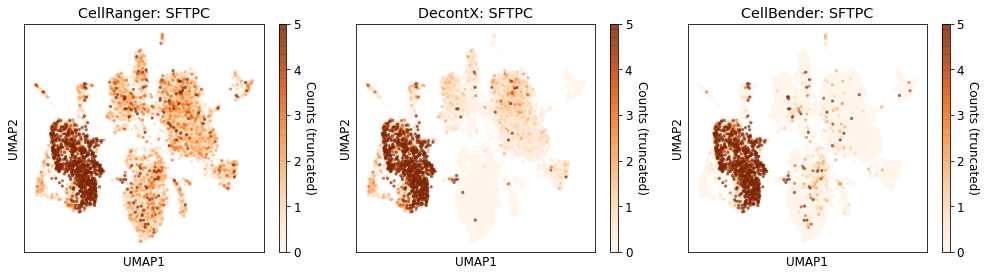

In [173]:
plt.rcParams.update({'font.size': 12})

vmax = 5

for g in ['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC']:
    
    fig = plt.figure(figsize=(14, 4))
    
    ax = plt.subplot(1, 3, 1)
    plot_umap(adata, color=g, layer='cellranger', ax=ax, 
              cmap='Oranges', 
              colorbar_label='Counts' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellRanger: ' + g)
    
    ax = plt.subplot(1, 3, 2)
    plot_umap(adata, color=g, layer='decontx', ax=ax, 
              cmap='Oranges', 
              colorbar_label='Counts' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('DecontX: ' + g)
    
    ax = plt.subplot(1, 3, 3)
    plot_umap(adata, color=g, layer='cellbender', ax=ax, 
              cmap='Oranges', 
              colorbar_label='Counts' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellBender: ' + g)
    
    plt.tight_layout()
    
    fig.savefig(f'/home/jupyter-user/analysis/figures/{g}_umap.pdf', bbox_inches='tight')
    
    plt.show()

## Subtraction of each gene

In [157]:
adata

AnnData object with n_obs × n_vars = 8179 × 26312
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels', 'Raw_LungMuus_Basal', 'Raw_LungMuus_Secretory', 'Raw_LungMuus_Ciliated', 'Raw_LungMuus_Tuft.like', 'Raw_LungMuus_Ionocytes', 'Raw_LungMuus_Neuroendocrine', 'Raw_LungMuus_AT1', 'Raw_LungMuus_AT2', 'Raw_LungMuus_Mesoth

In [15]:
for layer in ['cellranger', 'cellbender', 'decontx']:

    adata.var[layer + '_count'] = np.array(adata.layers[layer].sum(axis=0)).squeeze()

In [16]:
adata.var.head()

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count
gene_name,,,,,,,
AL627309.1,GRCh38premrna_ENSG00000238009,Gene Expression,GRCh38premrna,AL627309.1,40.0,40.0,35.024769
AL627309.2,GRCh38premrna_ENSG00000239906,Gene Expression,GRCh38premrna,AL627309.2,5.0,4.0,4.421344
AC114498.1,GRCh38premrna_ENSG00000235146,Gene Expression,GRCh38premrna,AC114498.1,3.0,3.0,2.831913
AL669831.5,GRCh38premrna_ENSG00000237491,Gene Expression,GRCh38premrna,AL669831.5,286.0,286.0,242.805649
FAM87B,GRCh38premrna_ENSG00000177757,Gene Expression,GRCh38premrna,FAM87B,2.0,2.0,1.868993


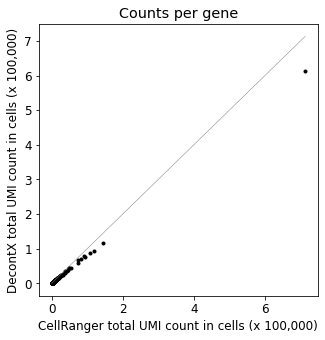

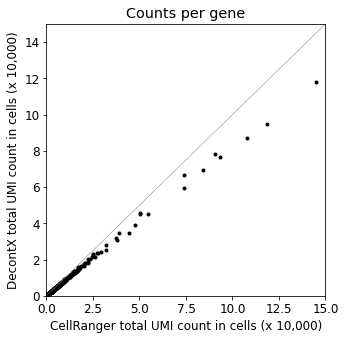

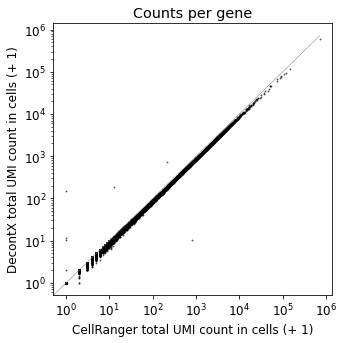

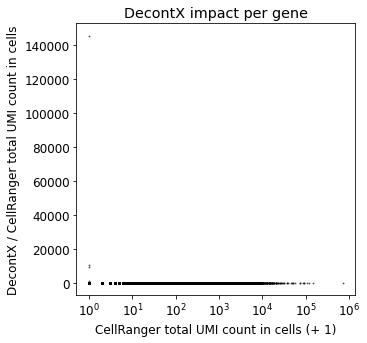

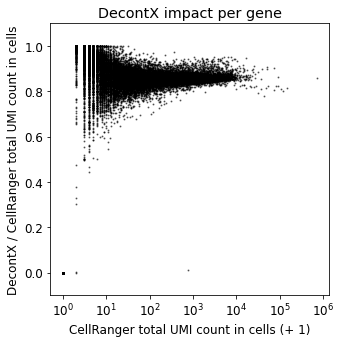

In [163]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e5, adata.var['decontx_count'] / 1e5, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e5], 
         [0, adata.var['cellranger_count'].max() / 1e5], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 100,000)')
plt.ylabel('DecontX total UMI count in cells (x 100,000)')
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e4, adata.var['decontx_count'] / 1e4, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e4], 
         [0, adata.var['cellranger_count'].max() / 1e4], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 10,000)')
plt.ylabel('DecontX total UMI count in cells (x 10,000)')
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, adata.var['decontx_count'] + 1, 
         'k.', ms=2, alpha=0.5)
plt.plot([0, adata.var['cellranger_count'].max()], 
         [0, adata.var['cellranger_count'].max()], color='gray', lw=0.5, ms=2)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('DecontX total UMI count in cells (+ 1)')
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, 
         adata.var['decontx_count'] / (adata.var['cellranger_count'] + 1e-3), 
         'k.', ms=2, alpha=0.5)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('DecontX / CellRanger total UMI count in cells')
plt.xscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('DecontX impact per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, 
         adata.var['decontx_count'] / (adata.var['cellranger_count'] + 1e-3), 
         'k.', ms=2, alpha=0.5)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('DecontX / CellRanger total UMI count in cells')
plt.xscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('DecontX impact per gene')
plt.ylim([-0.1, 1.1])
plt.show()

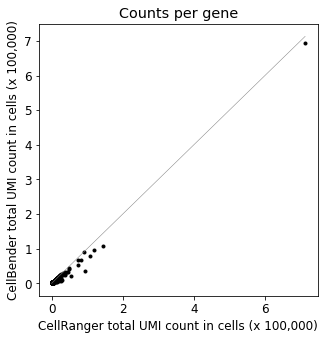

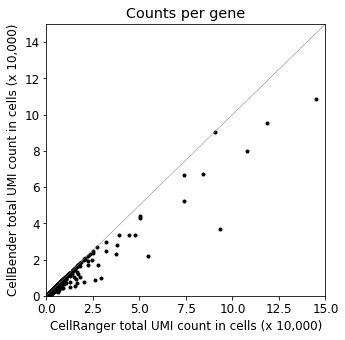

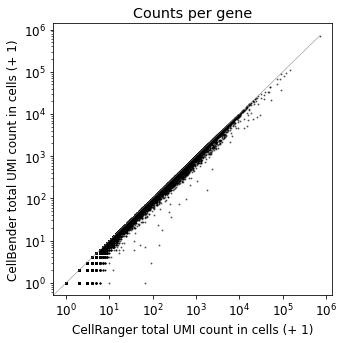

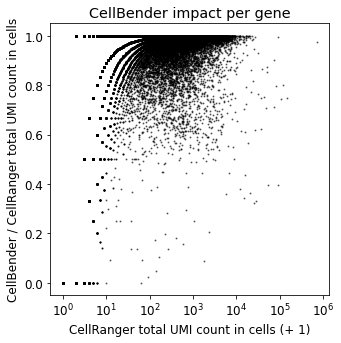

In [160]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e5, adata.var['cellbender_count'] / 1e5, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e5], 
         [0, adata.var['cellranger_count'].max() / 1e5], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 100,000)')
plt.ylabel('CellBender total UMI count in cells (x 100,000)')
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e4, adata.var['cellbender_count'] / 1e4, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e4], 
         [0, adata.var['cellranger_count'].max() / 1e4], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 10,000)')
plt.ylabel('CellBender total UMI count in cells (x 10,000)')
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, adata.var['cellbender_count'] + 1, 
         'k.', ms=2, alpha=0.5)
plt.plot([0, adata.var['cellranger_count'].max()], 
         [0, adata.var['cellranger_count'].max()], color='gray', lw=0.5, ms=2)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('CellBender total UMI count in cells (+ 1)')
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, 
         adata.var['cellbender_count'] / (adata.var['cellranger_count'] + 1e-3), 
         'k.', ms=2, alpha=0.5)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('CellBender / CellRanger total UMI count in cells')
plt.xscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('CellBender impact per gene')
plt.show()

In [164]:
adata.var['fraction_remaining_cellbender'] = \
    adata.var['cellbender_count'] / (adata.var['cellranger_count'] + 1e-3)

adata.var['fraction_remaining_decontx'] = \
    adata.var['decontx_count'] / (adata.var['cellranger_count'] + 1e-3)

In [167]:
adata.var[adata.var['cellranger_count'] > 50000].sort_values(by='fraction_remaining_cellbender', 
                                                             ascending=True).head(10)

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,fraction_remaining_cellbender,fraction_remaining_decontx
gene_name,,,,,,,,,
RASGEF1B,GRCh38premrna_ENSG00000138670,Gene Expression,GRCh38premrna,RASGEF1B,93150.0,36891.0,76710.609375,0.396039,0.823517
INO80D,GRCh38premrna_ENSG00000114933,Gene Expression,GRCh38premrna,INO80D,54864.0,21831.0,45142.632812,0.397911,0.822810
MT-ATP6,GRCh38premrna_ENSG00000198899,Gene Expression,GRCh38premrna,MT-ATP6,73954.0,52521.0,59763.449219,0.710185,0.808117
MT-CO2,GRCh38premrna_ENSG00000198712,Gene Expression,GRCh38premrna,MT-CO2,107679.0,80120.0,87322.187500,0.744063,0.810949
MT-ND3,GRCh38premrna_ENSG00000198840,Gene Expression,GRCh38premrna,MT-ND3,144942.0,108584.0,118037.445312,0.749155,0.814377
MT-CO1,GRCh38premrna_ENSG00000198804,Gene Expression,GRCh38premrna,MT-CO1,84284.0,67149.0,69489.664062,0.796699,0.824470
MT-ND2,GRCh38premrna_ENSG00000198763,Gene Expression,GRCh38premrna,MT-ND2,118610.0,95191.0,94816.179688,0.802555,0.799394
SFTPA1,GRCh38premrna_ENSG00000122852,Gene Expression,GRCh38premrna,SFTPA1,50313.0,42955.0,45282.523438,0.853755,0.900016
SFTPA2,GRCh38premrna_ENSG00000185303,Gene Expression,GRCh38premrna,SFTPA2,50474.0,44024.0,45701.449219,0.872211,0.905445


In [168]:
adata.var[adata.var['cellranger_count'] > 1000].sort_values(by='fraction_remaining_cellbender', 
                                                            ascending=True).head(10)

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,fraction_remaining_cellbender,fraction_remaining_decontx
gene_name,,,,,,,,,
S100A9,GRCh38premrna_ENSG00000163220,Gene Expression,GRCh38premrna,S100A9,1814.0,161.0,1520.741699,0.088754,0.838336
SLC30A10,GRCh38premrna_ENSG00000196660,Gene Expression,GRCh38premrna,SLC30A10,2388.0,491.0,1962.590332,0.205611,0.821855
S100A8,GRCh38premrna_ENSG00000143546,Gene Expression,GRCh38premrna,S100A8,1041.0,261.0,872.553284,0.250720,0.838187
SLC27A6,GRCh38premrna_ENSG00000113396,Gene Expression,GRCh38premrna,SLC27A6,26151.0,8498.0,21433.939453,0.324959,0.819622
SLC26A3,GRCh38premrna_ENSG00000091138,Gene Expression,GRCh38premrna,SLC26A3,29112.0,9664.0,24019.650391,0.331959,0.825077
LINGO1,GRCh38premrna_ENSG00000169783,Gene Expression,GRCh38premrna,LINGO1,15236.0,5262.0,12627.115234,0.345366,0.828768
UHRF2,GRCh38premrna_ENSG00000147854,Gene Expression,GRCh38premrna,UHRF2,5953.0,2137.0,4928.935059,0.358979,0.827975
MIB1,GRCh38premrna_ENSG00000101752,Gene Expression,GRCh38premrna,MIB1,20295.0,7408.0,16701.753906,0.365016,0.822949
CSMD1,GRCh38premrna_ENSG00000183117,Gene Expression,GRCh38premrna,CSMD1,12535.0,4771.0,10327.976562,0.380614,0.823931


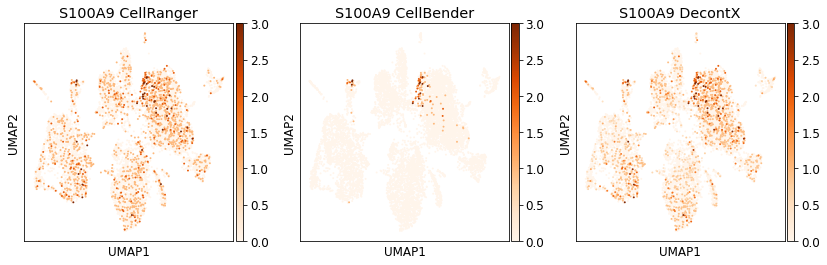

In [170]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
sc.pl.embedding(adata, basis='umap', color='S100A9', 
                color_map='Oranges', layer='cellranger', ax=plt.gca(), show=False, vmax=3, size=15)
plt.title('S100A9 CellRanger')
plt.subplot(1, 3, 2)
sc.pl.embedding(adata, basis='umap', color='S100A9', 
                color_map='Oranges', layer='cellbender', ax=plt.gca(), show=False, vmax=3, size=15)
plt.title('S100A9 CellBender')
plt.subplot(1, 3, 3)
sc.pl.embedding(adata, basis='umap', color='S100A9', 
                color_map='Oranges', layer='decontx', ax=plt.gca(), show=False, vmax=3, size=15)
plt.title('S100A9 DecontX')
plt.show()

### Does the subtraction make sense?

In [46]:
import tables

with tables.open_file('/home/jupyter-user/data/cellbender_v2/' + sample + '_out_FPR_0.01_filtered.h5') as f:
    ambient = f.root.matrix.ambient_expression.read()

In [47]:
adata.var['ambient'] = ambient

In [48]:
adata.var.sort_values(by='ambient', ascending=False).head(32)

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,fraction_remaining,ambient
gene_name,,,,,,,,
RASGEF1B,GRCh38premrna_ENSG00000138670,Gene Expression,GRCh38premrna,RASGEF1B,95229.0,38365.0,0.402871,0.030033
MT-ND3,GRCh38premrna_ENSG00000198840,Gene Expression,GRCh38premrna,MT-ND3,146911.0,110117.0,0.749549,0.021302
INO80D,GRCh38premrna_ENSG00000114933,Gene Expression,GRCh38premrna,INO80D,56095.0,22710.0,0.404849,0.017109
MT-CO2,GRCh38premrna_ENSG00000198712,Gene Expression,GRCh38premrna,MT-CO2,108959.0,81060.0,0.743950,0.016461
MT-ND2,GRCh38premrna_ENSG00000198763,Gene Expression,GRCh38premrna,MT-ND2,120216.0,96536.0,0.803021,0.013297
MT-ATP6,GRCh38premrna_ENSG00000198899,Gene Expression,GRCh38premrna,MT-ATP6,74751.0,53062.0,0.709850,0.012715
MALAT1,GRCh38premrna_ENSG00000251562,Gene Expression,GRCh38premrna,MALAT1,714914.0,696000.0,0.973544,0.011283
MT-CO1,GRCh38premrna_ENSG00000198804,Gene Expression,GRCh38premrna,MT-CO1,85461.0,68127.0,0.797171,0.010065
SLC26A3,GRCh38premrna_ENSG00000091138,Gene Expression,GRCh38premrna,SLC26A3,29687.0,10035.0,0.338027,0.009779


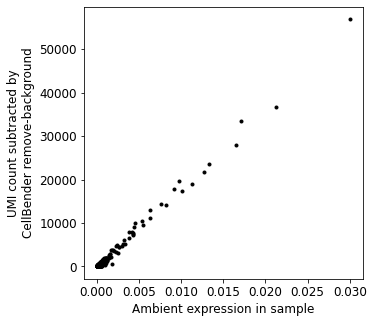

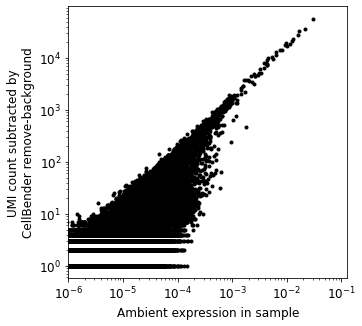

In [49]:
# ensure subtracted counts make sense

plt.figure(figsize=(5, 5))

plt.plot(adata.var['ambient'], adata.var['cellranger_count'] - adata.var['cellbender_count'], '.k')
plt.xlabel('Ambient expression in sample')
plt.ylabel('UMI count subtracted by\nCellBender remove-background')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['ambient'], adata.var['cellranger_count'] - adata.var['cellbender_count'], '.k')
plt.xlabel('Ambient expression in sample')
plt.ylabel('UMI count subtracted by\nCellBender remove-background')
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1e-6)
plt.show()

Subtracted counts are very much in line with the ambient profile.

## Changes in UMAP caused by CellBender

UMAPs are straight from Pegasus.

I am limiting the cells to be only those called as cells by the CellBender + Pegasus pipeline.

The coloring is the same for both: the leiden_labels from the CellBender + Pegasus pipeline.

In [38]:
sc.set_figure_params(vector_friendly=True)

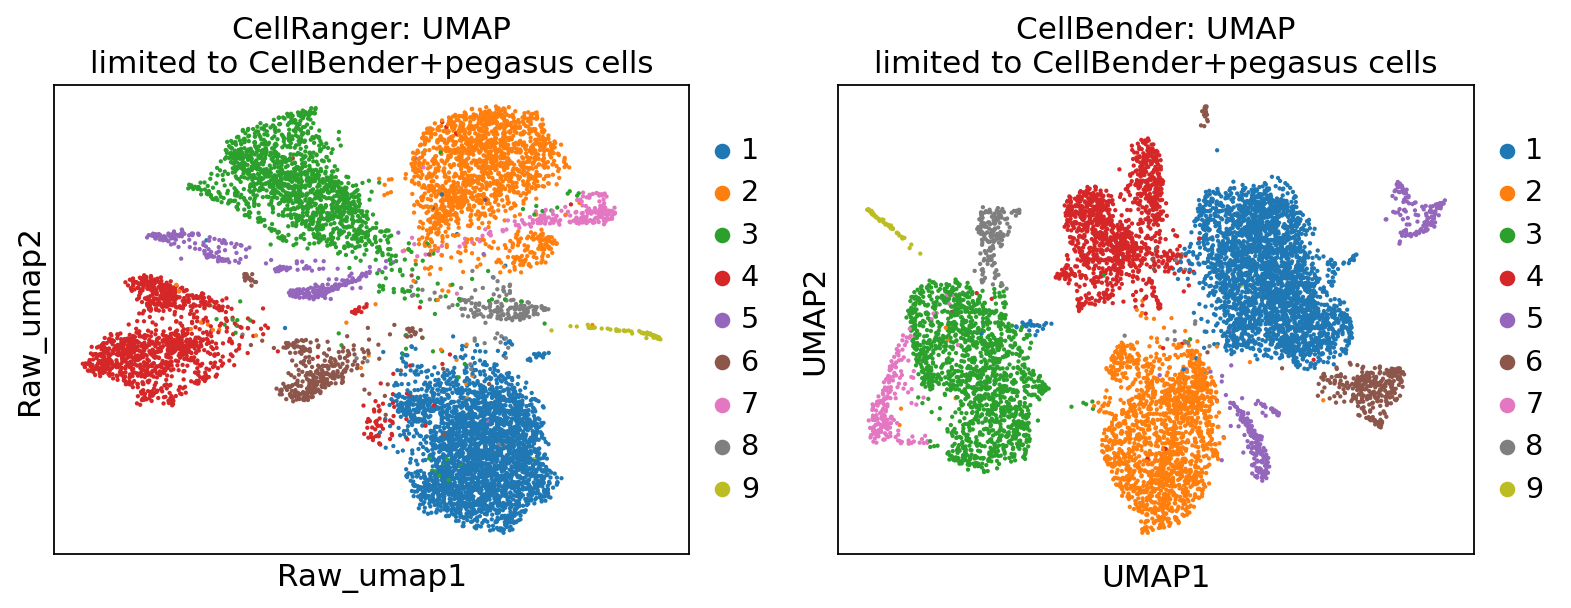

In [39]:
plt.rcParams.update({'font.size': 12})

cluster_key = 'leiden_labels'

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sc.pl.embedding(adata, basis='Raw_umap', color=cluster_key, 
                ax=plt.gca(), color_map='Oranges', size=15, show=False)
plt.title('CellRanger: UMAP\nlimited to CellBender+pegasus cells')

plt.subplot(1, 2, 2)
sc.pl.embedding(adata, basis='umap', color=cluster_key, 
                ax=plt.gca(), color_map='Oranges', size=15, show=False)
plt.title('CellBender: UMAP\nlimited to CellBender+pegasus cells')

plt.tight_layout()

fig.savefig('/home/jupyter-user/analysis/figures/cluster_umap.pdf', bbox_inches='tight')

plt.show()

### Include cells eliminated by cellbender remove-background

In [41]:
adata_pegasus_raw = \
    get_pegasus_data(sample=sample, directory='/home/jupyter-user/analysis/pegasus_raw')

adata_pegasus_raw

02-P005175-S053-R01
/home/jupyter-user/analysis/pegasus_raw/02-P005175-S053-R01*.h5ad
(10687, 26345)


AnnData object with n_obs × n_vars = 10687 × 26345
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'JerbyMelanoma_B_CELL', 'JerbyMelanoma_CAF', 'JerbyMelanoma_ENDOTHELIAL', 'JerbyMelanoma_MACROPHAGE', 'JerbyMelanoma_MALIGNANT', 'JerbyMelanoma_NK', 'JerbyMelanoma_T_CD4', 'JerbyMelanoma_T_CD8', 'JerbyMelanoma_T_CELL', 'JerbyMelanoma_STROMA', 'JerbyMelanoma_IMMUNE', 'JerbyMelanoma_T_CD4_EXHAUSTED', 'JerbyMelanoma_T_CD4_NAIVE', 'JerbyMelanoma_T_CD4_TREG', 'JerbyMelanoma_T_CD8_CYTOTOXIC', 'JerbyMelanoma_T_CD8_EXHAUSTED', 'JerbyMelanoma_T_CD8_NAIVE', 'HTAPP_epithelial', 'HTAPP_macrophage_nuc', 'HTAPP_tcell_nuc', 'HTAPP_bcell_nuc', 'HTAPP_mast_cell', 'HTAPP_fibrocyte', 'HTAPP_astrocytes', 'HTAPP_oligodendrocytes', 'HTAPP_microglia', 'HTAPP_skeletal_muscle_myocyte_nuc', 'HTAPP_melanoma_signature', 'HTAPP_melanocyte', 'HTAPP_hepatocyte', 'HTAPP_alveolar_rhabdomyosarcoma', 'HTAPP_Ewing_sarcoma', 'HTAPP_basal_cells', 'HTAPP_secretory_cells', 'HTAPP_ciliated_cells', 'HTAPP_gobl

In [42]:
adata_pegasus_raw.obs['leiden_labels'] = adata.obs['leiden_labels']

In [43]:
adata_pegasus_raw.obs['leiden_labels'].unique()

[1, NaN, 2, 3, 4, 6, 5, 9, 8, 7]
Categories (9, object): [1, 2, 3, 4, ..., 5, 9, 8, 7]

In [44]:
pd.isnull(adata_pegasus_raw.obs['leiden_labels']).sum()

2399

In [45]:
adata_pegasus_raw.obs['leiden_labels'].cat.set_categories(
    adata_pegasus_raw.obs['leiden_labels'].cat.categories.tolist() + ['x'], inplace=True)
adata_pegasus_raw.obs['leiden_labels'][pd.isnull(adata_pegasus_raw.obs['leiden_labels'])] = 'x'
adata_pegasus_raw.obs['leiden_labels'] = adata_pegasus_raw.obs['leiden_labels'].astype('category')

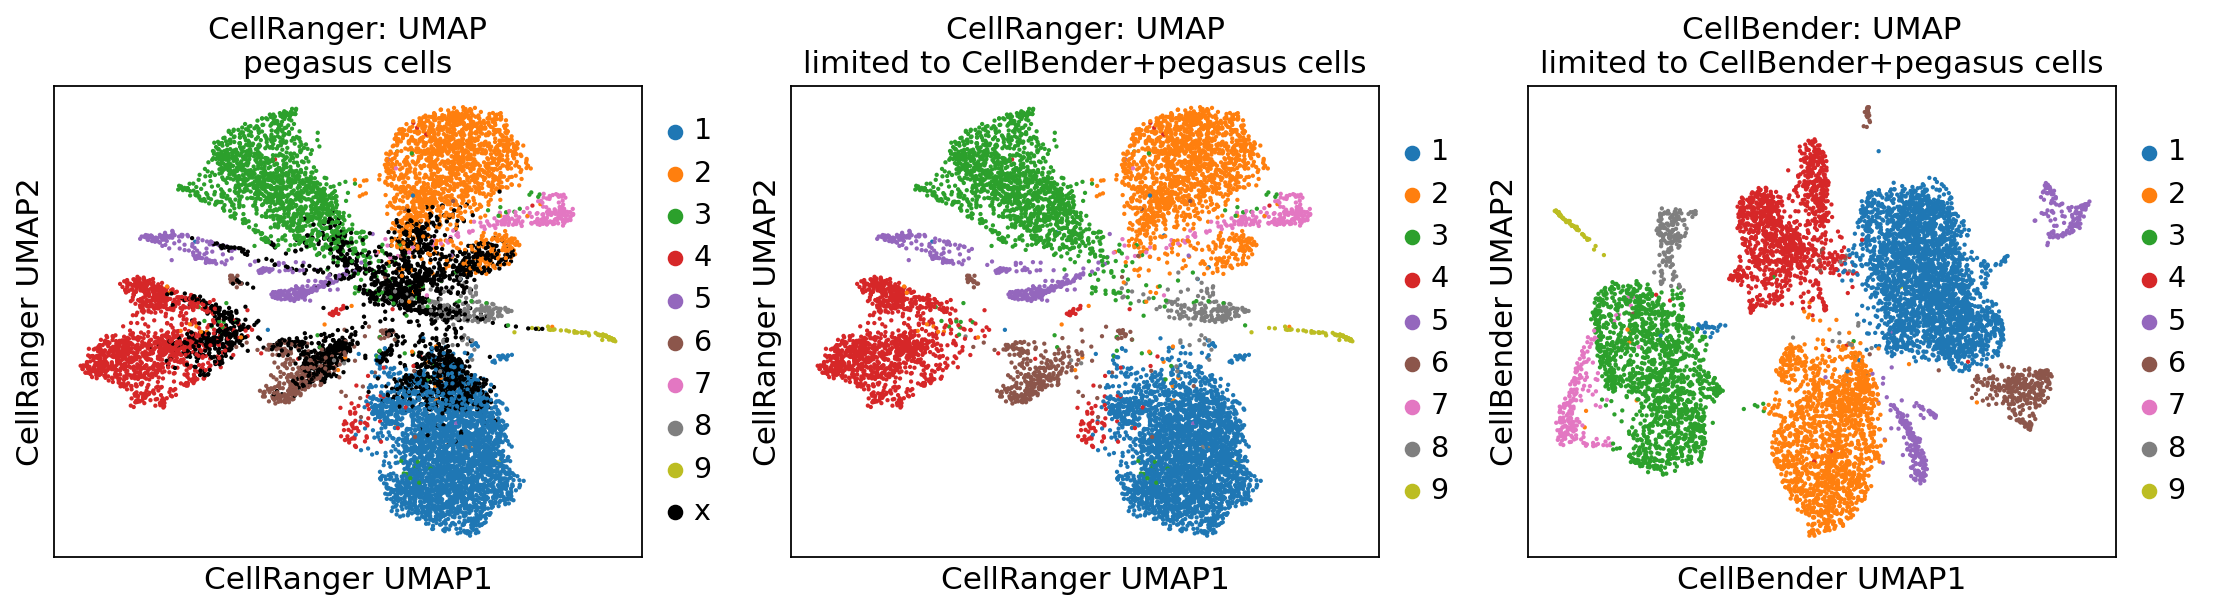

In [46]:
plt.rcParams.update({'font.size': 12})

cluster_key = 'leiden_labels'

fig = plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sc.pl.embedding(adata_pegasus_raw, basis='umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False, palette=adata.uns[cluster_key + '_colors'].tolist() + ['k'])
plt.title('CellRanger: UMAP\npegasus cells')
plt.xlabel('CellRanger UMAP1')
plt.ylabel('CellRanger UMAP2')

plt.subplot(1, 3, 2)
sc.pl.embedding(adata, basis='Raw_umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False)
plt.title('CellRanger: UMAP\nlimited to CellBender+pegasus cells')
plt.xlabel('CellRanger UMAP1')
plt.ylabel('CellRanger UMAP2')

plt.subplot(1, 3, 3)
sc.pl.embedding(adata, basis='umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False)
plt.title('CellBender: UMAP\nlimited to CellBender+pegasus cells')
plt.xlabel('CellBender UMAP1')
plt.ylabel('CellBender UMAP2')

plt.tight_layout()

fig.savefig('/home/jupyter-user/analysis/figures/cluster_umap_3.pdf', bbox_inches='tight')

plt.show()

In [47]:
set(adata.obs.index) - set(adata_pegasus_raw.obs.index)

set()

In [48]:
np.sum([bc not in adata_pegasus_raw.obs.index for bc in adata.obs.index])

0

## Counts removed per gene in cells versus empty droplets

In [17]:
adata.var.head()

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count
gene_name,,,,,,,
AL627309.1,GRCh38premrna_ENSG00000238009,Gene Expression,GRCh38premrna,AL627309.1,40.0,40.0,35.024769
AL627309.2,GRCh38premrna_ENSG00000239906,Gene Expression,GRCh38premrna,AL627309.2,5.0,4.0,4.421344
AC114498.1,GRCh38premrna_ENSG00000235146,Gene Expression,GRCh38premrna,AC114498.1,3.0,3.0,2.831913
AL669831.5,GRCh38premrna_ENSG00000237491,Gene Expression,GRCh38premrna,AL669831.5,286.0,286.0,242.805649
FAM87B,GRCh38premrna_ENSG00000177757,Gene Expression,GRCh38premrna,FAM87B,2.0,2.0,1.868993


In [47]:
adata_raw = sc.read_10x_h5('/home/jupyter-user/data/cellranger/' + sample + '.h5')
adata_raw.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [48]:
adata_raw.obs.index = [sample + '-' + s[:-2] for s in adata_raw.obs.index]

In [49]:
adata_raw

AnnData object with n_obs × n_vars = 6794880 × 33567
    var: 'gene_ids', 'feature_types', 'genome'

In [50]:
adata_empties = adata_raw[[bc for bc in adata_raw.obs.index if bc not in adata.obs.index]]

In [51]:
adata_empties

View of AnnData object with n_obs × n_vars = 6786699 × 33567
    var: 'gene_ids', 'feature_types', 'genome'

(50, 84617.75821664359)

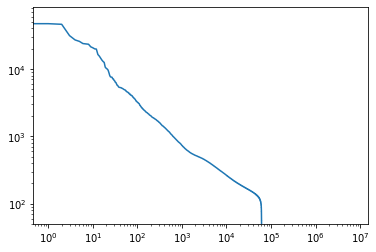

In [52]:
counts = np.array(adata_empties.X.sum(axis=1)).squeeze()

plt.loglog(sorted(counts, reverse=True))
plt.ylim(bottom=50)

In [53]:
adata_empties = adata_empties[(counts > 100) & (counts < 1000)]

In [54]:
adata_empties

View of AnnData object with n_obs × n_vars = 58844 × 33567
    var: 'gene_ids', 'feature_types', 'genome'

In [56]:
adata_empties.var['counts_per_empty'] = np.array(adata_empties.X.mean(axis=0)).squeeze()

Trying to set attribute `.var` of view, copying.


In [57]:
adata.var.head()

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count
gene_name,,,,,,,
AL627309.1,GRCh38premrna_ENSG00000238009,Gene Expression,GRCh38premrna,AL627309.1,40.0,40.0,35.024769
AL627309.2,GRCh38premrna_ENSG00000239906,Gene Expression,GRCh38premrna,AL627309.2,5.0,4.0,4.421344
AC114498.1,GRCh38premrna_ENSG00000235146,Gene Expression,GRCh38premrna,AC114498.1,3.0,3.0,2.831913
AL669831.5,GRCh38premrna_ENSG00000237491,Gene Expression,GRCh38premrna,AL669831.5,286.0,286.0,242.805649
FAM87B,GRCh38premrna_ENSG00000177757,Gene Expression,GRCh38premrna,FAM87B,2.0,2.0,1.868993


In [58]:
adata.var['removed_counts_per_cell'] = \
    (adata.var['cellranger_count'] - adata.var['cellbender_count']) / adata.shape[0]

In [64]:
empty_counts = adata_empties.var['counts_per_empty']

In [65]:
empty_counts.index = [s.split('_')[-1] for s in empty_counts.index]

In [66]:
empty_counts

MIR1302-2HG    0.000000
FAM138A        0.000000
OR4F5          0.000000
AL627309.1     0.000306
AL627309.3     0.000000
                 ...   
ORF8           0.000017
N              0.000017
ORF10          0.000085
3prime         0.000136
NegStrand      0.000000
Name: counts_per_empty, Length: 33567, dtype: float32

In [68]:
adata.var['counts_per_empty'] = empty_counts

In [69]:
adata.var.head()

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,removed_counts_per_cell,counts_per_empty
gene_name,,,,,,,,,
AL627309.1,GRCh38premrna_ENSG00000238009,Gene Expression,GRCh38premrna,AL627309.1,40.0,40.0,35.024769,0.000000,0.000306
AL627309.2,GRCh38premrna_ENSG00000239906,Gene Expression,GRCh38premrna,AL627309.2,5.0,4.0,4.421344,0.000122,0.000000
AC114498.1,GRCh38premrna_ENSG00000235146,Gene Expression,GRCh38premrna,AC114498.1,3.0,3.0,2.831913,0.000000,0.000068
AL669831.5,GRCh38premrna_ENSG00000237491,Gene Expression,GRCh38premrna,AL669831.5,286.0,286.0,242.805649,0.000000,0.001767
FAM87B,GRCh38premrna_ENSG00000177757,Gene Expression,GRCh38premrna,FAM87B,2.0,2.0,1.868993,0.000000,0.000000


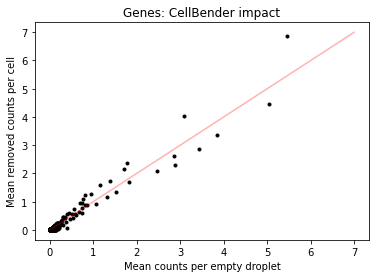

In [73]:
plt.plot(adata.var['counts_per_empty'].values, 
         adata.var['removed_counts_per_cell'].values, '.k')
plt.plot([0, 7], [0, 7], '-', color='red', alpha=0.3)
plt.xlabel('Mean counts per empty droplet')
plt.ylabel('Mean removed counts per cell')
plt.title('Genes: CellBender impact')
plt.show()

In [74]:
adata.var['removed_counts_per_cell_decontx'] = \
    (adata.var['cellranger_count'] - adata.var['decontx_count']) / adata.shape[0]

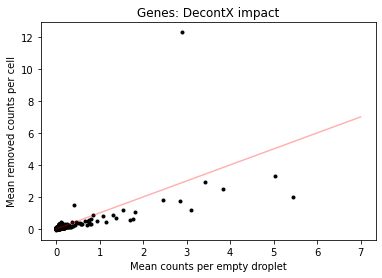

In [75]:
plt.plot(adata.var['counts_per_empty'].values, 
         adata.var['removed_counts_per_cell_decontx'].values, '.k')
plt.plot([0, 7], [0, 7], '-', color='red', alpha=0.3)
plt.xlabel('Mean counts per empty droplet')
plt.ylabel('Mean removed counts per cell')
plt.title('Genes: DecontX impact')
plt.show()

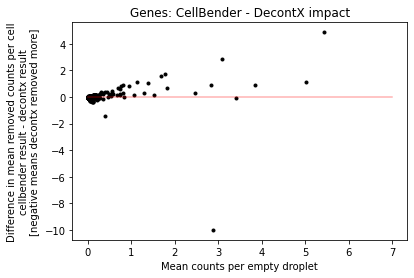

In [82]:
plt.plot(adata.var['counts_per_empty'].values, 
         adata.var['removed_counts_per_cell'].values
         - adata.var['removed_counts_per_cell_decontx'].values, '.k')
plt.plot([0, 7], [0, 0], '-', color='red', alpha=0.3)
plt.xlabel('Mean counts per empty droplet')
plt.ylabel('Difference in mean removed counts per cell'
           '\ncellbender result - decontx result\n' 
           '[negative means decontx removed more]')
plt.title('Genes: CellBender - DecontX impact')
plt.show()

In [83]:
adata.var[(adata.var['removed_counts_per_cell'].values
           - adata.var['removed_counts_per_cell_decontx'].values) < -1]

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,removed_counts_per_cell,counts_per_empty,removed_counts_per_cell_decontx
gene_name,,,,,,,,,,
NEAT1,GRCh38premrna_ENSG00000245532,Gene Expression,GRCh38premrna,NEAT1,90988.0,90549.0,78681.953125,0.053661,0.405917,1.504223
MALAT1,GRCh38premrna_ENSG00000251562,Gene Expression,GRCh38premrna,MALAT1,714416.0,695652.0,613806.562500,2.293607,2.888235,12.297938


In [85]:
adata.var[(adata.var['removed_counts_per_cell'].values
           - adata.var['removed_counts_per_cell_decontx'].values) > 1]

,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,removed_counts_per_cell,counts_per_empty,removed_counts_per_cell_decontx
gene_name,,,,,,,,,,
INO80D,GRCh38premrna_ENSG00000114933,Gene Expression,GRCh38premrna,INO80D,54901.0,21850.0,45178.085938,4.039971,3.097555,1.188475
RASGEF1B,GRCh38premrna_ENSG00000138670,Gene Expression,GRCh38premrna,RASGEF1B,93191.0,36903.0,76749.546875,6.880332,5.444264,2.009712
SLC27A6,GRCh38premrna_ENSG00000113396,Gene Expression,GRCh38premrna,SLC27A6,26158.0,8498.0,21440.527344,2.158660,1.696614,0.576638
SLC26A3,GRCh38premrna_ENSG00000091138,Gene Expression,GRCh38premrna,SLC26A3,29121.0,9665.0,24028.185547,2.378193,1.770454,0.622517
MIB1,GRCh38premrna_ENSG00000101752,Gene Expression,GRCh38premrna,MIB1,20303.0,7409.0,16709.359375,1.576091,1.145878,0.439267
FTL,GRCh38premrna_ENSG00000087086,Gene Expression,GRCh38premrna,FTL,37470.0,23259.0,31995.343750,1.737074,1.382514,0.669192
MT-ND3,GRCh38premrna_ENSG00000198840,Gene Expression,GRCh38premrna,MT-ND3,145408.0,109029.0,118498.312500,4.446767,5.033642,3.289291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


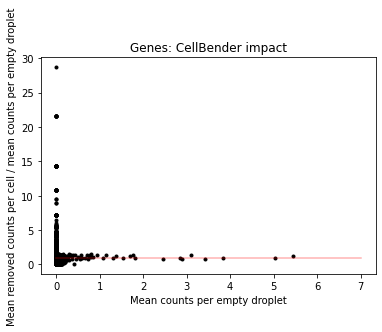

In [87]:
plt.plot(adata.var['counts_per_empty'].values, 
         adata.var['removed_counts_per_cell'].values
         / adata.var['counts_per_empty'].values, '.k')
plt.plot([0, 7], [1, 1], '-', color='red', alpha=0.3)
plt.xlabel('Mean counts per empty droplet')
plt.ylabel('Mean removed counts per cell / mean counts per empty droplet')
plt.title('Genes: CellBender impact')
plt.show()

In [96]:
adata.var[((adata.var['removed_counts_per_cell'].values
            / adata.var['counts_per_empty'].values) > 1.2)
          & (adata.var['counts_per_empty'].values > 0.5)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


,gene_ids,feature_types,genome,gene_name,cellranger_count,cellbender_count,decontx_count,removed_counts_per_cell,counts_per_empty,removed_counts_per_cell_decontx
gene_name,,,,,,,,,,
INO80D,GRCh38premrna_ENSG00000114933,Gene Expression,GRCh38premrna,INO80D,54901.0,21850.0,45178.085938,4.039971,3.097555,1.188475
RASGEF1B,GRCh38premrna_ENSG00000138670,Gene Expression,GRCh38premrna,RASGEF1B,93191.0,36903.0,76749.546875,6.880332,5.444264,2.009712
SLC27A6,GRCh38premrna_ENSG00000113396,Gene Expression,GRCh38premrna,SLC27A6,26158.0,8498.0,21440.527344,2.158660,1.696614,0.576638
ACTB,GRCh38premrna_ENSG00000075624,Gene Expression,GRCh38premrna,ACTB,15649.0,9541.0,13360.999023,0.746608,0.566393,0.279673
SLC26A3,GRCh38premrna_ENSG00000091138,Gene Expression,GRCh38premrna,SLC26A3,29121.0,9665.0,24028.185547,2.378193,1.770454,0.622517
TMSB4X,GRCh38premrna_ENSG00000205542,Gene Expression,GRCh38premrna,TMSB4X,16183.0,7095.0,13775.243164,1.110867,0.772517,0.294311
CSMD1,GRCh38premrna_ENSG00000183117,Gene Expression,GRCh38premrna,CSMD1,12547.0,4776.0,10339.378906,0.949884,0.702341,0.269847
FTH1,GRCh38premrna_ENSG00000167996,Gene Expression,GRCh38premrna,FTH1,18276.0,10349.0,15507.748047,0.968952,0.746087,0.338376
B2M,GRCh38premrna_ENSG00000166710,Gene Expression,GRCh38premrna,B2M,27567.0,17114.0,23659.785156,1.277717,0.944305,0.477596


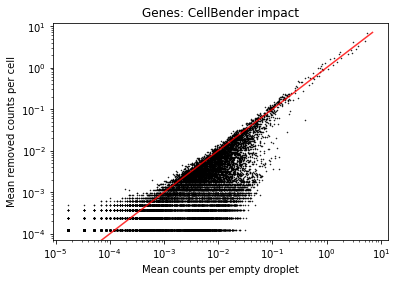

In [90]:
plt.plot(adata.var['counts_per_empty'].values, 
         adata.var['removed_counts_per_cell'].values, '.k', ms=1)
plt.plot([0, 7], [0, 7], '-', color='red', alpha=0.8)
plt.xlabel('Mean counts per empty droplet')
plt.ylabel('Mean removed counts per cell')
plt.title('Genes: CellBender impact')
plt.xscale('log')
plt.yscale('log')
plt.show()